In [1]:
import os
import numpy as np
from numpy.random import randint, uniform
import pandas as pd
from matplotlib.image import imsave
from scipy.signal import unit_impulse
from astropy.convolution import convolve_fft
from skimage.draw import line
import cv2


def sqr(x: float) -> float: return x * x

class Beams(object):
    rgb = 255
    def __init__(self, shape: tuple = (512, 512)) -> None:
        self.shape = shape
        self.kernels = None
    
    def point_beam(self, point: tuple = (0, 0), max_int: int = None) -> np.array:
        if max_int is None:
            max_int = self.rgb
        coords = (point[0] + self.shape[0]//2, point[1] + self.shape[1]//2)
        return unit_impulse(self.shape, coords) * max_int
    
    def two_points_beam(
            self, d: int, alpha: float, point: tuple = (0, 0), max_int: int = None
        ) -> np.array:
        x0, y0 = point
        point2 = (int(x0 + d * np.sin(alpha)), int(y0 + d * np.cos(alpha)))
        two_points = self.point_beam(point) + self.point_beam(point2, max_int=max_int)
        return two_points / np.max(two_points) * self.rgb
    
    def gauss_beam(
            self, b_maj: int, b_min: int, b_pa: float, 
            shape: tuple = None, point: tuple = (0, 0),
            max_int: int = None, degrees: bool = False
        ) -> np.array:
        if shape is None: shape = self.shape
        if max_int is None: max_int = self.rgb
        if degrees: b_pa = np.deg2rad(b_pa)

        # FIXME: b_maj is not sigma
        x0, y0 = point
        a = (sqr(np.cos(b_pa)) / (2 * sqr(b_maj)) + 
             sqr(np.sin(b_pa)) / (2 * sqr(b_min)))
        b = (-np.sin(2 * b_pa) / (4 * sqr(b_maj)) + 
             np.sin(2 * b_pa) / (4 * sqr(b_min)))
        c = (sqr(np.sin(b_pa)) / (2 * sqr(b_maj)) + 
             sqr(np.cos(b_pa)) / (2 * sqr(b_min)))
        x, y = np.meshgrid(np.linspace(-shape[0]//2, shape[0]//2-1, shape[0]), 
                           np.linspace(-shape[1]//2, shape[1]//2-1, shape[1]))
        e = np.exp(-(a * sqr(x-x0) + 2 * b * (x-x0) * (y-y0) + c * sqr(y-y0)))
        return e * max_int
    
    def _point_beam(self, point: tuple = (0, 0)) -> np.array:
        return self.gauss_beam(1, 1, 0, point=point)

    def two_gauss_beam(
            self, b_maj1: int, b_min1: int, b_pa1: float, 
            b_maj2: int, b_min2: int, b_pa2: float,
            d: int, alpha: float, point: tuple = (0, 0), 
            max_int: int = None
        ) -> np.array:
        x0, y0 = point
        point2 = (int(x0 + d * np.sin(alpha)), int(y0 + d * np.cos(alpha)))
        gauss1 = self.gauss_beam(b_maj1, b_min1, b_pa1, point=point)
        gauss2 = self.gauss_beam(b_maj2, b_min2, b_pa2, point=point2, max_int=max_int)
        two_gauss = gauss1 + gauss2
        return two_gauss / np.max(two_gauss) * self.rgb
    
    def _two_points_beam(
            self, d: int, alpha: float, point: tuple = (0, 0)
        ) -> np.array:
        return self.two_gauss_beam(1, 1, 0, 1, 1, 0, d, alpha, point=point)
    
    def gauss_w_jet_beam(
            self, b_maj: int, b_min: int, b_pa: float,
            d: int, alpha: float, point: tuple = (0, 0)
        ) -> np.array:
        x0, y0 = self.shape[0]//2 + point[0], self.shape[1]//2 + point[1]
        gauss_w_jet = self.gauss_beam(b_maj, b_min, b_pa, point=point)
        jet = (int(x0 + d * np.sin(alpha)), int(y0 + d * np.cos(alpha)))
        rr, cc = line(x0, y0, jet[0], jet[1])
        gauss_w_jet[rr, cc] = self.rgb
        return gauss_w_jet
    
    def gauss_w_two_jets_beam(
            self, b_maj: int, b_min: int, b_pa: float,
            d: int, alpha: float, point: tuple = (0, 0)
        ) -> np.array:
        x0, y0 = self.shape[0]//2 + point[0], self.shape[1]//2 + point[1]
        gauss_w_jets = self.gauss_beam(b_maj, b_min, b_pa, point=point)
        jet1 = (int(x0 - d * np.sin(alpha)), int(y0 - d * np.cos(alpha)))
        jet2 = (int(x0 + d * np.sin(alpha)), int(y0 + d * np.cos(alpha)))
        rr, cc = line(jet1[0], jet1[1], jet2[0], jet2[1])
        gauss_w_jets[rr, cc] = self.rgb # intensity(radius)
        return gauss_w_jets
    
    def gauss_w_spiral_beam(
            self, b_maj: int, b_min: int, b_pa: float,
            v: float, c: float, w: float, phi: float, point: tuple = (0, 0)
        ) -> np.array:
        x0, y0 = self.shape[0]//2 + point[0], self.shape[1]//2 + point[1]
        gauss = self.gauss_beam(b_maj, b_min, b_pa, point=point)
        t = np.linspace(0, self.shape[0]//8-1, self.rgb)
        x = np.array((v * t + c) * np.cos(w * t + phi) + x0).astype(int)
        y = np.array((v * t + c) * np.sin(w * t + phi) + y0).astype(int)
        gauss[x, y] = self.rgb
        return gauss

    def draw_beam(self, beam: np.array, filename: str, path: str = None) -> None:
        if path is None: path = 'src/astrogeo/test'
        if not os.path.exists(path): os.makedirs(path)
        imsave(f'{path}/{filename}.png', np.log10(beam + 1), origin='lower')
        # fig, ax = plt.subplots(figsize=(10, 8))
        # beam += 1
        # im = ax.imshow(np.log10(beam), interpolation='none', origin='lower')
        # ax.set_xlabel('x [pixels]')
        # ax.set_ylabel('y [pixels]')
        # fig.colorbar(im)
        # fig.savefig(f'{path}/{filename}', dpi=500)
        # plt.close(fig)
    
    def conv(self, model: np.array, kernel: np.array) -> np.array:
        c = convolve_fft(model, kernel, boundary='wrap')
        return c / np.max(c) * self.rgb
    
    def test_beams(self) -> list:
        d, alpha = self.shape[0]//4, np.pi/4
        b_maj, b_min, b_pa = 15, 10, np.pi/4
        b_maj2, b_min2, b_pa2 = 8, 8, 0
        v, c, w = 1, 0, 0.05
        beams = [
            self.point_beam(), self.two_points_beam(d, alpha),
            self.gauss_beam(b_maj, b_min, b_pa),
            self.two_gauss_beam(
                b_maj, b_min, b_pa, b_maj2, b_min2, b_pa2, d, alpha
            ),
            self.gauss_w_jet_beam(b_maj, b_min, b_pa, d, alpha),
            self.gauss_w_two_jets_beam(b_maj, b_min, b_pa, d, alpha),
            self.gauss_w_spiral_beam(b_maj, b_min, b_pa, v, c, w, alpha)
        ]
        return beams
    
    def draw_test_beams(self) -> None:
        beams = self.test_beams()
        file_names = ['point_beam.png', 'two_point_beam.png',
                      'gauss_beam.png',  'two_gauss_beam.png', 
                      'gauss_w_jet_beam.png', 'gauss_w_two_jets_beam.png',
                      'gauss_w_spiral_beam.png']
        for beam, name in zip(beams, file_names):
            self.draw_beam(beam, name)
    
    def kernel(
            self, b_maj: int, b_min: int, b_pa: float,
            shape: tuple = None, point: tuple = (0, 0)
        ) -> np.array:
        if shape is None:
            shape = self.shape # (self.shape[0]//8, self.shape[1]//8)
        return self.gauss_beam(
            b_maj, b_min, b_pa,
            shape=shape, point=point, degrees=True
        )
    
    def get_kernels(self, cluster_means: pd.DataFrame) -> list:
        if self.kernels is not None:
            return self.kernels
        rows = cluster_means.shape[0]
        alpha, ratio = np.sqrt(np.log10(2)), 6 # wtf is this 
        self.kernels = []
        for row in range(rows):
            datum = cluster_means.loc[row].to_list()[1:4]
            sigma = max(datum[0], datum[1]) / alpha
            sh = np.ceil(ratio * sigma).astype(int)
            kernel_size = (sh, sh)
            k = self.kernel(*datum, shape=kernel_size)
            self.kernels.append(k)
        return self.kernels
    
    def draw_kernels(self, cluster_means: pd.DataFrame) -> None:
        kernels = self.get_kernels(cluster_means)
        for ind, kernel in enumerate(kernels):
            self.draw_beam(kernel, f'kernel_{ind}')
    
    def conv_beams(
            self, cluster_means: pd.DataFrame,
            path: str, aug: bool = False,
            n: int = 10
        ) -> None:
        models = self.augmentation(n) if aug else self.test_beams()
        kernels = self.get_kernels(cluster_means)
        kernel_num = len(kernels)
        if aug:
            k_i = 0
            for ind, model in zip(range(kernel_num * n + 1), models):
                m_i = ind if ind == 0 else (ind-1) // n + 1
                if not os.path.exists(f'{path}/{m_i}'):
                    os.makedirs(f'{path}/{m_i}')
                for kernel in kernels:
                    self.draw_beam(
                        self.conv(model, kernel),
                        str(k_i), path=f'{path}/{m_i}'
                    )
                    k_i += 1
        else:
            for m_i, model in enumerate(models):
                if not os.path.exists(f'{path}/{m_i}'):
                    os.makedirs(f'{path}/{m_i}')
                for k_i, kernel in enumerate(kernels):
                    self.draw_beam(
                        self.conv(model, kernel),
                        str(k_i), path=f'{path}/{m_i}'
                    )
    
    def augmentation(self, n: int = 10) -> list:
        Dist = (self.shape[0]//6, self.shape[0]//5)
        Alpha = (0, 2 * np.pi) #
        Max_int = (60, self.rgb) # <--- change low bound
        B_maj = (1, 3) # 
        B_min = B_maj
        B_pa = Alpha
        V, C, W = (0.5, 2.5), (-1, 1), (0.06, 0.01) # <---
        beams = [] # [self.add_noise(self.point_beam())] # One point
        '''
        # Two points
        for _ in range(n):
            d = randint(*Dist)
            max_int = randint(*Max_int)
            alpha = uniform(*Alpha)
            model = self.two_points_beam(d, alpha, max_int=max_int)
            beams.append(self.add_noise(model))
        
        '''
        # One gaussian
        for _ in range(n):
            b_maj, b_min = randint(*B_maj), randint(*B_min)
            b_pa = uniform(*B_pa)
            model = self.gauss_beam(b_maj, b_min, b_pa)
            beams.append(self.add_noise(model))
        
        # Two gaussians
        for _ in range(n):
            b_maj, b_maj2 = randint(*B_maj), randint(*B_maj)
            b_min, b_min2 = randint(*B_min), randint(*B_min)
            b_pa, b_pa2 = uniform(*B_pa), uniform(*B_pa)
            d, max_int = randint(*Dist), randint(*Max_int)
            alpha = uniform(*Alpha)
            model = self.two_gauss_beam(
                b_maj, b_min, b_pa,
                b_maj2, b_min2, b_pa2,
                d, alpha, max_int=max_int)
            beams.append(self.add_noise(model))
        
        # Gaussian with a jet
        for _ in range(n):
            b_maj, b_min = randint(*B_maj), randint(*B_min)
            b_pa, alpha = uniform(*B_pa), uniform(*Alpha)
            d = randint(*Dist)
            print(f'Jet size {d}, beam maj {b_maj}')
            model = self.gauss_w_jet_beam(
                b_maj, b_min, b_pa, d, alpha)
            beams.append(self.add_noise(model))

        # Gaussian with two jets
        for _ in range(n):
            b_maj, b_min = randint(*B_maj), randint(*B_min)
            b_pa, alpha = uniform(*B_pa), uniform(*Alpha)
            d = randint(*Dist)
            print(f'Double jet size {d}, beam maj {b_maj}')
            model = self.gauss_w_two_jets_beam(
                b_maj, b_min, b_pa, d, alpha)
            beams.append(self.add_noise(model))
        
        # Gaussian with a spiral
        '''
        for _ in range(n):
            b_maj, b_min = randint(*B_maj), randint(*B_min)
            b_pa, alpha = uniform(*B_pa), uniform(*Alpha)
            v, c, w = uniform(*V), uniform(*C), uniform(*W)
            beams.append(self.gauss_w_spiral_beam(
                b_maj, b_min, b_pa, v, c, w, alpha)
            )
        '''
        return beams
    
    def draw_aug_beams(self, path: str) -> None:
        beams = self.augmentation()
        for ind, beam in enumerate(beams):
            self.draw_beam(beam, str(ind), path)
    
    def add_noise(self, im: np.array) -> np.array:
        noise = np.zeros(self.shape)
        cv2.randn(noise, 0, 5) # 5
        un_img = cv2.add(im, noise)
        return np.abs(un_img)

In [2]:
cluster_means = pd.read_csv('../cluster_means.csv')
b = Beams()
b.conv_beams(cluster_means=cluster_means, path='../test2', n=1, aug=True)

Jet size 98, beam maj 2
Double jet size 87, beam maj 1


In [4]:
shape = (512, 512)
rgb = 255
Dist = (shape[0]//6, shape[0]//3)
Alpha = (-np.pi/2, np.pi/2)
Max_int = (60, rgb)
B_maj = (1, 5)
B_min = B_maj
B_pa = Alpha
V, C, W = (0.5, 2.5), (-1, 1), (0.06, 0.01)

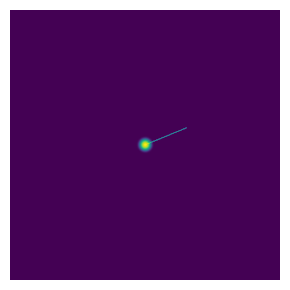

b_maj=4, b_min=4, b_pa=-0.07, d=85, alpha=0.39


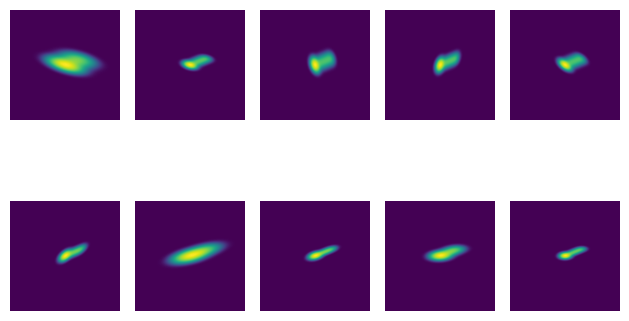

In [61]:
import matplotlib.pyplot as plt

b_maj, b_min = 4, 4
b_pa, alpha = uniform(*B_pa), uniform(*Alpha)
d = randint(*Dist)
b = Beams(shape)

beam = b.gauss_w_jet_beam(b_maj, b_min, b_pa, d, alpha)
fig_orig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(np.log10(beam + 1), origin='lower')
ax.axis('off')
fig_orig.tight_layout()
plt.show()
print(f'b_maj={b_maj}, b_min={b_min}, b_pa={b_pa:.2f}, d={d}, alpha={alpha:.2f}')

fig, axes = plt.subplots(2, 5)
kernels = b.get_kernels(cluster_means)
for k_i, kernel in enumerate(kernels):
    beam_conv = b.conv(beam, kernel)
    axes[k_i // 5][k_i % 5].imshow(np.log10(beam_conv + 1), origin='lower')
    axes[k_i // 5][k_i % 5].axis('off')
fig.tight_layout()
plt.show()


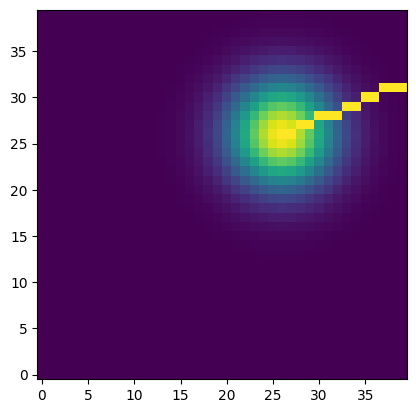

In [62]:
ax = plt.imshow(beam[230:270, 230:270], origin='lower')

In [117]:
np.uint8(-2)

/var/folders/05/4ldl3cjn6rb1nmn5rxy1grb40000gn/T/ipykernel_73996/2831579327.py:1: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -2 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  np.uint8(-2)


254

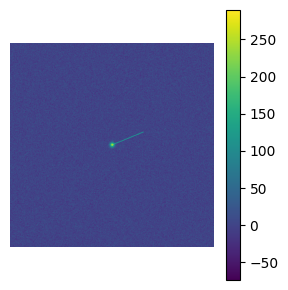

In [139]:
import cv2

noise = np.zeros(shape)
cv2.randn(noise, 0, 15)
# noise = (noise).astype(np.uint8)
un_img = cv2.add(beam, noise)

# Можно брать абсолютное значение
# un_img -= un_img.min()
# un_img = un_img / un_img.max() * 255

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
# im = ax.imshow(np.log10((un_img).astype(np.int16) + 1), origin='lower')
im = ax.imshow(un_img, origin='lower')
ax.axis('off')
fig.colorbar(im)
fig.tight_layout()
plt.show()

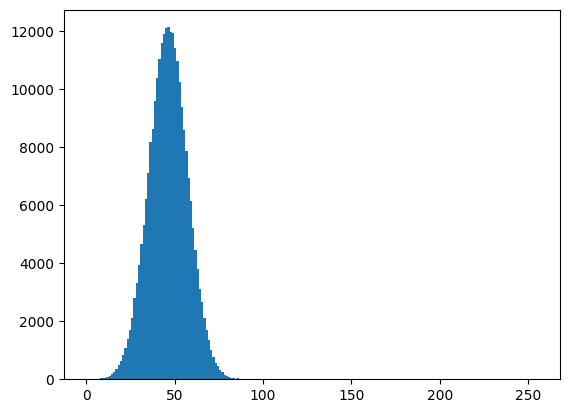

In [138]:
ax = plt.hist(un_img.reshape((1, -1)).squeeze(), bins=200)

In [123]:
k = 0.1
b1, b2 = int(k * un_img.shape[0]), int(k * un_img.shape[1])
b3, b4 = int((1-k) * un_img.shape[0]), int((1-k) * un_img.shape[1])
upper_left = np.std(un_img[:b1, :b2])
upper_right = np.std(un_img[b3:, :b2])
down_left = np.std(un_img[:b1, b4:])
down_right = np.std(un_img[b3:, b4:])
noise = np.median([upper_left, upper_right, down_left, down_right])
noise

15.018788119861572

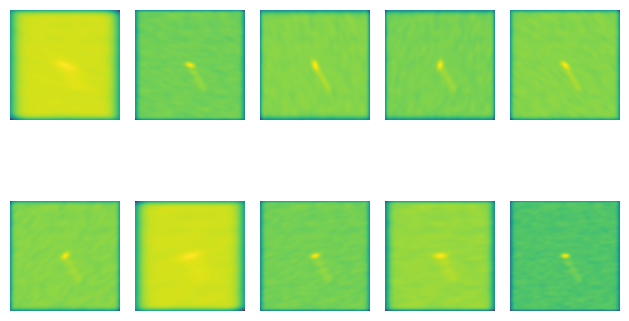

In [60]:
fig, axes = plt.subplots(2, 5)
kernels = b.get_kernels(cluster_means)
for k_i, kernel in enumerate(kernels):
    beam_conv = b.conv(un_img, kernel)
    axes[k_i // 5][k_i % 5].imshow(np.log10(beam_conv + 1), origin='lower')
    axes[k_i // 5][k_i % 5].axis('off')
fig.tight_layout()
plt.show()

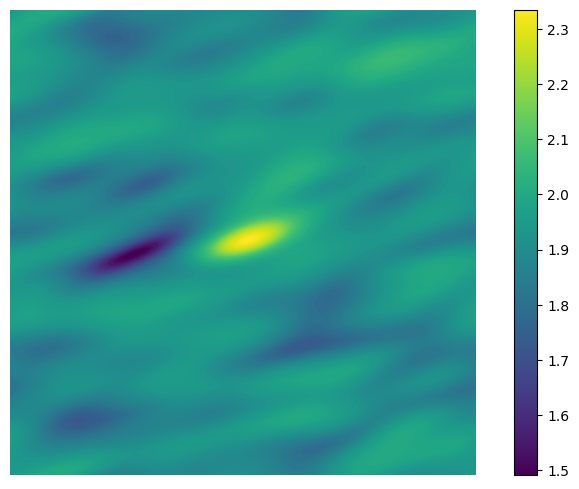

In [113]:
import cv2

im = cv2.imread('../test/0/0.png')
img_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
im = ax.imshow(np.log10((img_gray).astype(np.int16) + 1), origin='lower')
ax.axis('off')
fig.colorbar(im)
fig.tight_layout()
plt.show()